In [ ]:
import os
REPOSITORY_PATH = r'/home/luis-felipe/UncEst'
DATA_PATH = os.path.join(REPOSITORY_PATH,'data')
#CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = os.path.join(REPOSITORY_PATH,'torch_models')
PATH_TRAINER = os.path.join(PATH_MODELS,'trainer')

PATH_FIGS = os.path.join(REPOSITORY_PATH,'figs','MCDropout')

In [14]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from collections import defaultdict
import random
from copy import copy,deepcopy

In [15]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


In [16]:
import NN_models as models
import NN_utils as utils
import NN_utils.train_and_eval as TE
import torch_data

In [17]:
import uncertainty.metrics as metrics
from uncertainty.MonteCarlo_Dropout import MonteCarloDropout

In [18]:
data

Trainining data length = 0 
Validation data length = 0 
 Test data length = 10000

In [19]:
MODEL_ARC = 'ResNet50'
REAL_DATA = 'Cifar10'
DATA = 'ImbalanceBinary'+REAL_DATA
IMB_RATIO = 0.01
NAME = MODEL_ARC +'_' + DATA

WEIGTH_FILE = f'_{IMB_RATIO}_'
data_real = torch_data.__dict__[REAL_DATA](data_dir = DATA_PATH, train = False)
Binary_LT_data = torch_data.__dict__[DATA](data_dir = DATA_PATH,train= False)
data = Binary_data = torch_data.src.Binary_DataGenerators(deepcopy(data_real))
model_class = models.__dict__[MODEL_ARC]

weights_path = os.path.join(PATH_MODELS,MODEL_ARC,DATA)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
def weights_files(weights_path):
    #Get all weight files in weights_path
    files = [f for f in os.listdir(weights_path) if os.path.isfile(os.path.join(weights_path, f)) and f.endswith(".pt")]
    files = sorted(files)
    return files

def upload_weights(file, weights_path):
    
    def file_with_name(name,files):
        for f in files:
            if name in f:
                return f
        else: raise Exception(f"No file with {name} in files list")

    files = weights_files(weights_path)

    if isinstance(file,int):
        weights = files[file]
        weights = os.path.join(weights_path,weights)
    elif file == 'random':
        weights = random.choice(files)
        weights = os.path.join(weights_path,weights)
    elif file == 'max':
        return upload_weights(0, weights_path)
    elif isinstance(file,str):
        if file in files:
            weights = os.path.join(weights_path,file)
        elif file+'.pt' in files:
            weights = os.path.join(weights_path,file+'.pt')
        else:
            file = file_with_name(file,files)
            return upload_weights(file, weights_path)
    else: raise Exception("No correct file specified")
    state_dict = torch.load(weights)
    return state_dict

In [21]:
model = model_class(num_classes = 1).to(dev)
model.classifier = torch.nn.Sequential(model.classifier, torch.nn.Sigmoid())
model.eval()
model.load_state_dict(upload_weights(WEIGTH_FILE, weights_path))
print(f'Acurácia (modelo determinístico): {TE.model_acc(model,data.test_dataloader)}')

Acurácia (modelo determinístico): 86.66


In [22]:
hits = dict.fromkeys(sorted(data_real.test_data.targets),0)

In [23]:
with torch.no_grad():
    hits = dict.fromkeys(sorted(data_real.test_data.targets),0)
    for im,label in data_real.test_dataloader:
        im,label = im.to(dev),label.to(dev)
        label_binary = label%2
        output = model(im)
        correct = TE.correct_class(output,label_binary)
        for i,l in enumerate(label):
            hits[l.item()] += correct[i].int().item()
    

In [24]:
hits

{0: 987,
 1: 980,
 2: 951,
 3: 794,
 4: 904,
 5: 836,
 6: 874,
 7: 702,
 8: 880,
 9: 758}

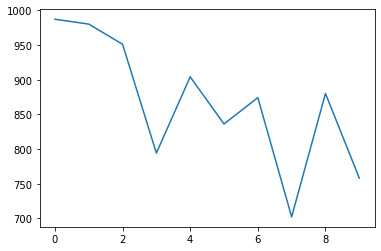

In [25]:
plt.plot(hits.keys(),hits.values())